Import Python Libraries

In [2]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import random
from google.colab.patches import cv2_imshow
import cv2
from tensorflow.keras.models import load_model

In [3]:
TRAINING_DIR = "/dataset/images/train"

- Get a list of all JPEG files in the training directory
- Choose a random JPEG file from the list
- Load the image using OpenCV

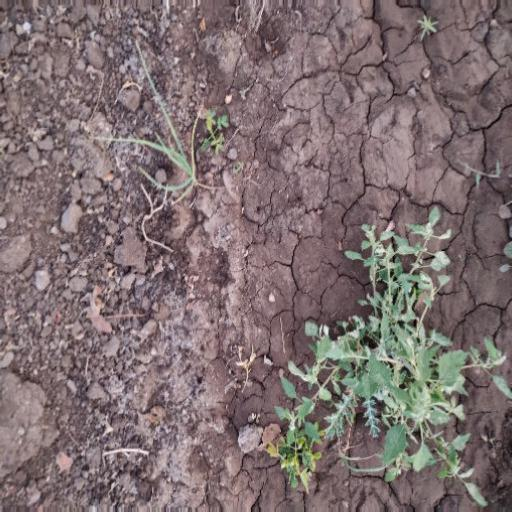

In [4]:
jpeg_files = [f for f in os.listdir(TRAINING_DIR) if f.endswith('.jpeg')] 
random_jpeg_file = random.choice(jpeg_files)
image = cv2.imread(os.path.join(TRAINING_DIR, random_jpeg_file))
cv2_imshow(image)

- Paths for train and val image directories
- Paths for train and val label directories

In [5]:
train_image_dir = "dataset/images/train"
val_image_dir = "dataset/images/val"
train_label_dir = "dataset/labels/train"
val_label_dir = "dataset/labels/val"

def load_images_and_labels(image_dir, label_dir):
    images = []
    labels = []
    image_filenames = os.listdir(image_dir)
    for filename in image_filenames:
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        if image is None:
            continue  
        images.append(image)
        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_path = os.path.join(label_dir, label_filename)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label_content = f.read()
        else:
            label_content = ""
        labels.append(label_content)
    return np.array(images), labels

train_images, train_labels = load_images_and_labels(train_image_dir, train_label_dir)
val_images, val_labels = load_images_and_labels(val_image_dir, val_label_dir)

preprocess image 
- resize to height = 128 , width = 128 
- convert it into array using numpy

In [6]:
def preprocess_images(images):
    preprocessed = []
    for img in images:
        resized = cv2.resize(img, (128, 128))
        preprocessed.append(resized.astype('float32') / 255.0)
    return np.array(preprocessed)

train_images_proc = preprocess_images(train_images)
val_images_proc = preprocess_images(val_images)

convert labels into array using numpy

In [7]:
def parse_labels(label_texts):
    classes = []
    for label in label_texts:
        if label.strip():
            first_line = label.strip().split('\n')[0]
            class_id = int(first_line.split()[0])
        else:
            class_id = 0 
        classes.append(class_id)
    return np.array(classes)

train_class_ids = parse_labels(train_labels)
val_class_ids = parse_labels(val_labels)

In [8]:
X = np.concatenate((train_images_proc, val_images_proc), axis=0)
y = np.concatenate((train_class_ids, val_class_ids), axis=0)

In [9]:
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes=num_classes)

train , test split , 20 % for testing rest 80% for training

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

Sequential model with 64 dense layer , activation ='relu' 

In [12]:
model = Sequential([
    Conv2D(128, (3, 3), activation="relu", input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model Training.............................

In [14]:
history=model.fit(datagen.flow(X_train, y_train, batch_size=16), epochs=50, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.4769 - loss: 0.7053 - val_accuracy: 0.5017 - val_loss: 0.6882
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5164 - loss: 0.6919 - val_accuracy: 0.8528 - val_loss: 0.6905
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.6274 - loss: 0.6913 - val_accuracy: 0.5017 - val_loss: 0.6851
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.5928 - loss: 0.6458 - val_accuracy: 0.8896 - val_loss: 0.3585
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8191 - loss: 0.4497 - val_accuracy: 0.9130 - val_loss: 0.3197
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8172 - loss: 0.4289 - val_accuracy: 0.8930 - val_loss: 0.3478
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.8810 - loss: 0.3377 - val_accuracy: 0.8361 - val_loss: 0.4081
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8847 - loss: 0.3386 - val_accuracy: 0.9030 - val_loss: 

In [15]:
import matplotlib.pyplot as plt

Visualization . . . . . . . . . . . . . . . . . . . . .

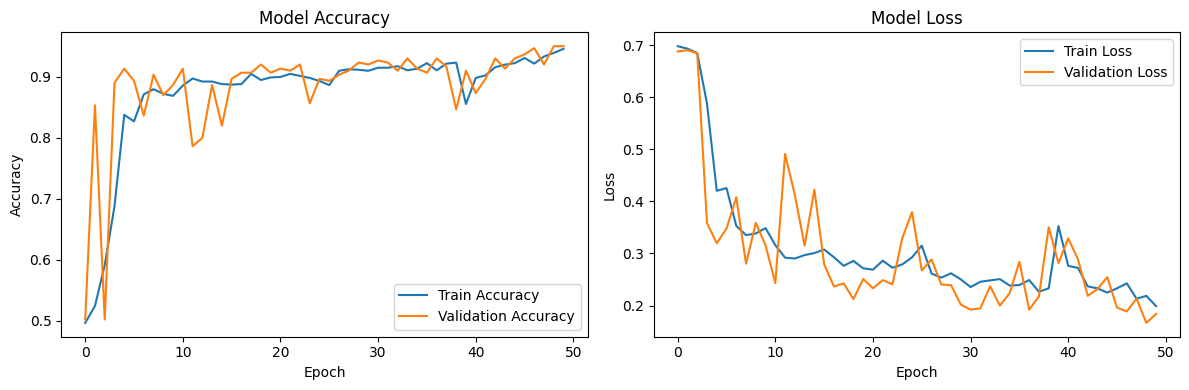

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Testing on test data achieve accuracy of 94% with loss of 18%

In [17]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.18397599458694458
Test accuracy: 0.9498327970504761


In [18]:
model.save("/content/data/Trained-model/trained-model.h5")

- Accuracy: 0.9498327759197325
- Precision: 0.9470198675496688 ( checks the correct prediction)
- Recall: 0.9533333333333334 ( checks th)
- F1 Score: 0.9501661129568106



 Precision measures the proportion of correct positive predictions made by the model, reflecting the accuracy of the positive identifications and minimizing false positives.

 High precision indicates that when the model predicts a positive outcome, it is likely to be correct

 Recall, also known as the true positive rate or sensitivity, measures the proportion of actual positive instances that the model successfully identifies.
 It focuses on the completeness of positive detection and minimizes false negatives.

 High recall means the model captures most of the relevant cases

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step
Accuracy: 0.9498327759197325
Precision: 0.9470198675496688
Recall: 0.9533333333333334
F1 Score: 0.9501661129568106


In [21]:
MODEL_PATH = "data/Trained-model/trained-model.h5"
model = load_model(MODEL_PATH)
CLASS_NAMES = {0: "Crop", 1: "Weed"}

Model Prediction , on test data

In [22]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Could not read image at {image_path}")
    resized = cv2.resize(image, (128, 128))
    preprocessed = resized.astype('float32') / 255.0
    preprocessed = np.expand_dims(preprocessed, axis=0)
    return preprocessed, image

def predict_image(image_path):
    processed_image, original_image = preprocess_image(image_path)
    predictions = model.predict(processed_image, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100
    predicted_class = CLASS_NAMES.get(predicted_class_idx, f"Class {predicted_class_idx}")

    print(f"Prediction: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"\nAll Class Probabilities:")

    for idx, prob in enumerate(predictions[0]):
        class_name = CLASS_NAMES.get(idx, f"Class {idx}")
        print(f"  {class_name}: {prob * 100:.2f}%")
    print(f"{'='*50}\n")

    return predicted_class, confidence, predictions[0]

def predict_multiple_images(image_paths):
    results = []
    for image_path in image_paths:
        try:
            predicted_class, confidence, all_probs = predict_image(image_path)
            results.append({
                'image_path': image_path,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'all_probabilities': all_probs
            })
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")

    return results

In [24]:
if __name__ == "__main__":
    image_path = "/weed_1.jpeg"
    predict_image(image_path)


Image: weed_1.jpeg
Prediction: Weed
Confidence: 99.55%

All Class Probabilities:
  Crop: 0.45%
  Weed: 99.55%

Inference script ready!
Use predict_image(image_path) for single image prediction
Use predict_multiple_images(image_paths) for batch prediction
